In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchsummary  

from trainer import Trainer 
from tester import Tester
from utils import  visualize_data,show_misclassified_images,plot_class_distribution,plot_confusion_matrix,plot_curves,denormalize
from dataloader import Cifar10DataLoader,Cifar10Dataset
from vistransformers import train_transforms,test_transforms
from model import Network

c:\Users\muthu\miniconda3\envs\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.amp.autocast(enabled=True,dtype=torch.float16)
torch.set_float32_matmul_precision('medium')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Is CUDA available? ", use_cuda)

Is CUDA available?  True


In [3]:
# CIFAR10 Data
train_data = Cifar10Dataset(root='../../data',train=True,download=False,transform=train_transforms)
test_data = Cifar10Dataset(root='../../data',train=False,download=False,transform=test_transforms)

# CIFAR10 DataLoader
loader = Cifar10DataLoader(batch_size=32,is_cuda_available=True)
train_loader = loader.get_loader(train_data,train=True)
test_loader  = loader.get_loader(test_data,train=False)

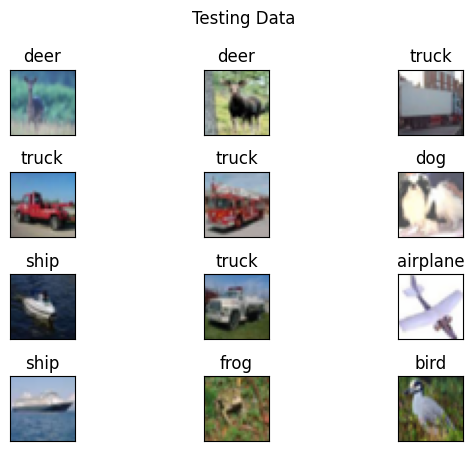

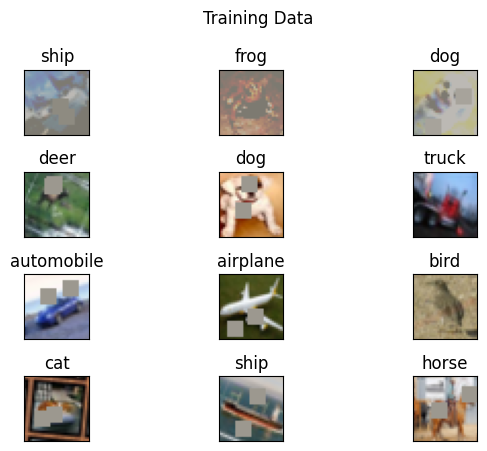

In [4]:
visualize_data(test_loader,12,"Testing Data",classes=test_data.classes);
visualize_data(train_loader,12,"Training Data",classes=train_data.classes);

In [5]:
model  = Network().to(device=device)
torchsummary.summary(model,(3,32,32),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
         Dropout2d-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
         Dropout2d-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,304
             ReLU-10           [-1, 16, 32, 32]               0
      BatchNorm2d-11           [-1, 16, 32, 32]              32
        Dropout2d-12           [-1, 16, 32, 32]               0
           Conv2d-13            [-1, 8, 32, 32]           1,152
      BatchNorm2d-14            [-1, 8,

 67%|██████▋   | 67/100 [00:01<00:00, 60.18it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.97E-01


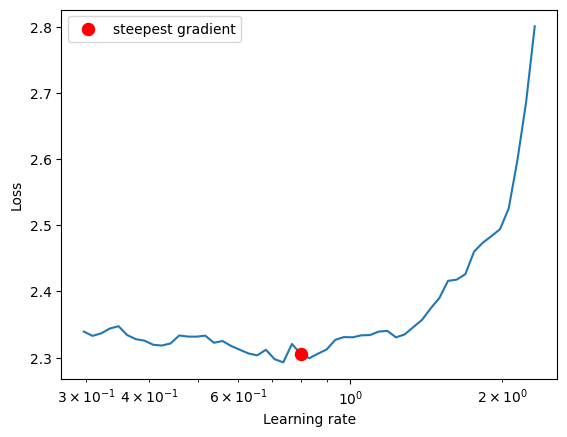

In [6]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)

lr_finder = LRFinder(model,optimizer,criterion,device=device)
lr_finder.range_test(train_loader,end_lr=10,num_iter=100,step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [7]:
EPOCH  = 50
current_accuracy = 80.27  # Target

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=7.97E-01, 
                                          pct_start=5/EPOCH,
                                          anneal_strategy='linear',
                                          cycle_momentum=True,
                                          base_momentum=0.85,
                                          max_momentum=0.95,
                                          steps_per_epoch=len(train_loader),
                                          epochs= EPOCH,
                                          three_phase=False,
                                          div_factor=100,
                                          final_div_factor=100
            )



trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)


for epoch in range(0, EPOCH):
    trainer.train(epoch=epoch)
    test_acc,test_loss = tester.test()
    scheduler.step()
    if test_acc>current_accuracy:
        current_accuracy = test_acc
        # Model Save
        torch.save({
                        'model': model.state_dict(),
                        'optimizer':optimizer.state_dict(),
                        'scheduler':scheduler.state_dict(),
                        'epoch': epoch
                    },
                    "./assets/modelcifar10_{}.pth".format(test_acc)
        )
    print('-'*150)

EPOCH=0| LR=0.007970| LOSS=1.70| BATCH=1562| ACCURACY=33.608: 100%|██████████| 1563/1563 [00:25<00:00, 61.18it/s]
LOSS=464.63| BATCH=312| ACCURACY=45.570: 100%|██████████| 313/313 [00:08<00:00, 38.63it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=1| LR=0.008071| LOSS=1.66| BATCH=1562| ACCURACY=40.828: 100%|██████████| 1563/1563 [00:25<00:00, 61.60it/s]
LOSS=413.36| BATCH=312| ACCURACY=51.330: 100%|██████████| 313/313 [00:07<00:00, 39.27it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=2| LR=0.008172| LOSS=1.29| BATCH=1562| ACCURACY=44.858: 100%|██████████| 1563/1563 [00:24<00:00, 63.52it/s]
LOSS=374.96| BATCH=312| ACCURACY=56.570: 100%|██████████| 313/313 [00:07<00:00, 39.18it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=3| LR=0.008273| LOSS=1.10| BATCH=1562| ACCURACY=48.290: 100%|██████████| 1563/1563 [00:27<00:00, 55.93it/s]
LOSS=342.44| BATCH=312| ACCURACY=60.660: 100%|██████████| 313/313 [00:08<00:00, 36.70it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=4| LR=0.008374| LOSS=1.68| BATCH=1562| ACCURACY=50.478: 100%|██████████| 1563/1563 [00:25<00:00, 60.59it/s]
LOSS=313.70| BATCH=312| ACCURACY=64.300: 100%|██████████| 313/313 [00:08<00:00, 37.68it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=5| LR=0.008475| LOSS=1.35| BATCH=1562| ACCURACY=52.580: 100%|██████████| 1563/1563 [00:25<00:00, 61.01it/s]
LOSS=294.98| BATCH=312| ACCURACY=66.840: 100%|██████████| 313/313 [00:08<00:00, 37.64it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=6| LR=0.008576| LOSS=1.31| BATCH=1562| ACCURACY=53.986: 100%|██████████| 1563/1563 [00:25<00:00, 60.68it/s]
LOSS=283.87| BATCH=312| ACCURACY=67.770: 100%|██████████| 313/313 [00:08<00:00, 37.87it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=7| LR=0.008677| LOSS=1.09| BATCH=1562| ACCURACY=55.254: 100%|██████████| 1563/1563 [00:28<00:00, 55.13it/s]
LOSS=274.06| BATCH=312| ACCURACY=69.620: 100%|██████████| 313/313 [00:08<00:00, 36.81it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=8| LR=0.008778| LOSS=1.00| BATCH=1562| ACCURACY=56.402: 100%|██████████| 1563/1563 [00:28<00:00, 55.14it/s]
LOSS=262.20| BATCH=312| ACCURACY=70.770: 100%|██████████| 313/313 [00:08<00:00, 36.42it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=9| LR=0.008879| LOSS=1.66| BATCH=1562| ACCURACY=56.930: 100%|██████████| 1563/1563 [00:28<00:00, 54.88it/s]
LOSS=258.70| BATCH=312| ACCURACY=70.430: 100%|██████████| 313/313 [00:08<00:00, 35.19it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=10| LR=0.008980| LOSS=1.51| BATCH=1562| ACCURACY=57.972: 100%|██████████| 1563/1563 [00:28<00:00, 55.29it/s]
LOSS=254.86| BATCH=312| ACCURACY=71.680: 100%|██████████| 313/313 [00:08<00:00, 37.02it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=11| LR=0.009081| LOSS=1.13| BATCH=1562| ACCURACY=58.588: 100%|██████████| 1563/1563 [00:29<00:00, 53.44it/s]
LOSS=243.73| BATCH=312| ACCURACY=73.190: 100%|██████████| 313/313 [00:08<00:00, 36.67it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=12| LR=0.009182| LOSS=1.20| BATCH=1562| ACCURACY=59.100: 100%|██████████| 1563/1563 [00:28<00:00, 54.84it/s]
LOSS=243.09| BATCH=312| ACCURACY=73.520: 100%|██████████| 313/313 [00:08<00:00, 36.15it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=13| LR=0.009283| LOSS=0.74| BATCH=1562| ACCURACY=59.592: 100%|██████████| 1563/1563 [00:29<00:00, 53.81it/s]
LOSS=243.06| BATCH=312| ACCURACY=73.080: 100%|██████████| 313/313 [00:08<00:00, 36.62it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=14| LR=0.009384| LOSS=1.48| BATCH=1562| ACCURACY=59.964: 100%|██████████| 1563/1563 [00:28<00:00, 53.95it/s]
LOSS=244.77| BATCH=312| ACCURACY=72.480: 100%|██████████| 313/313 [00:08<00:00, 36.20it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=15| LR=0.009485| LOSS=1.58| BATCH=1562| ACCURACY=60.572: 100%|██████████| 1563/1563 [00:28<00:00, 54.63it/s]
LOSS=233.00| BATCH=312| ACCURACY=74.070: 100%|██████████| 313/313 [00:08<00:00, 36.00it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=16| LR=0.009586| LOSS=0.75| BATCH=1562| ACCURACY=60.650: 100%|██████████| 1563/1563 [00:28<00:00, 54.25it/s]
LOSS=228.50| BATCH=312| ACCURACY=74.290: 100%|██████████| 313/313 [00:08<00:00, 36.95it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=17| LR=0.009687| LOSS=1.15| BATCH=1562| ACCURACY=61.094: 100%|██████████| 1563/1563 [00:28<00:00, 54.09it/s]
LOSS=226.80| BATCH=312| ACCURACY=74.960: 100%|██████████| 313/313 [00:08<00:00, 36.88it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=18| LR=0.009788| LOSS=1.05| BATCH=1562| ACCURACY=61.230: 100%|██████████| 1563/1563 [00:28<00:00, 55.21it/s]
LOSS=223.23| BATCH=312| ACCURACY=75.360: 100%|██████████| 313/313 [00:08<00:00, 36.37it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=19| LR=0.009889| LOSS=1.42| BATCH=1562| ACCURACY=61.856: 100%|██████████| 1563/1563 [00:26<00:00, 58.08it/s]
LOSS=217.61| BATCH=312| ACCURACY=75.450: 100%|██████████| 313/313 [00:08<00:00, 37.65it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=20| LR=0.009990| LOSS=1.25| BATCH=1562| ACCURACY=62.044: 100%|██████████| 1563/1563 [00:27<00:00, 56.86it/s]
LOSS=216.83| BATCH=312| ACCURACY=75.740: 100%|██████████| 313/313 [00:08<00:00, 36.97it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=21| LR=0.010091| LOSS=1.10| BATCH=1562| ACCURACY=62.536: 100%|██████████| 1563/1563 [00:28<00:00, 55.57it/s]
LOSS=215.24| BATCH=312| ACCURACY=76.170: 100%|██████████| 313/313 [00:08<00:00, 36.98it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=22| LR=0.010191| LOSS=1.43| BATCH=1562| ACCURACY=62.610: 100%|██████████| 1563/1563 [00:28<00:00, 55.53it/s]
LOSS=211.47| BATCH=312| ACCURACY=76.630: 100%|██████████| 313/313 [00:08<00:00, 37.63it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=23| LR=0.010292| LOSS=1.03| BATCH=1562| ACCURACY=63.192: 100%|██████████| 1563/1563 [00:25<00:00, 60.15it/s]
LOSS=204.12| BATCH=312| ACCURACY=77.510: 100%|██████████| 313/313 [00:08<00:00, 38.33it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=24| LR=0.010393| LOSS=1.04| BATCH=1562| ACCURACY=63.332: 100%|██████████| 1563/1563 [00:26<00:00, 58.22it/s]
LOSS=205.01| BATCH=312| ACCURACY=77.400: 100%|██████████| 313/313 [00:08<00:00, 38.52it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=25| LR=0.010494| LOSS=1.38| BATCH=1562| ACCURACY=63.438: 100%|██████████| 1563/1563 [00:25<00:00, 60.88it/s]
LOSS=204.99| BATCH=312| ACCURACY=77.520: 100%|██████████| 313/313 [00:08<00:00, 37.56it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=26| LR=0.010595| LOSS=1.52| BATCH=1562| ACCURACY=63.790: 100%|██████████| 1563/1563 [00:25<00:00, 60.94it/s]
LOSS=204.73| BATCH=312| ACCURACY=77.130: 100%|██████████| 313/313 [00:08<00:00, 37.55it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=27| LR=0.010696| LOSS=1.47| BATCH=1562| ACCURACY=63.886: 100%|██████████| 1563/1563 [00:25<00:00, 60.90it/s]
LOSS=206.28| BATCH=312| ACCURACY=77.380: 100%|██████████| 313/313 [00:08<00:00, 37.80it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=28| LR=0.010797| LOSS=1.72| BATCH=1562| ACCURACY=63.946: 100%|██████████| 1563/1563 [00:26<00:00, 59.70it/s]
LOSS=198.56| BATCH=312| ACCURACY=78.160: 100%|██████████| 313/313 [00:08<00:00, 37.09it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=29| LR=0.010898| LOSS=1.00| BATCH=1562| ACCURACY=64.090: 100%|██████████| 1563/1563 [00:28<00:00, 55.00it/s]
LOSS=192.54| BATCH=312| ACCURACY=78.970: 100%|██████████| 313/313 [00:08<00:00, 36.95it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=30| LR=0.010999| LOSS=1.33| BATCH=1562| ACCURACY=64.344: 100%|██████████| 1563/1563 [00:25<00:00, 60.12it/s]
LOSS=195.94| BATCH=312| ACCURACY=78.460: 100%|██████████| 313/313 [00:08<00:00, 36.54it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=31| LR=0.011100| LOSS=1.33| BATCH=1562| ACCURACY=64.678: 100%|██████████| 1563/1563 [00:29<00:00, 53.80it/s]
LOSS=194.86| BATCH=312| ACCURACY=78.390: 100%|██████████| 313/313 [00:08<00:00, 38.13it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=32| LR=0.011201| LOSS=1.02| BATCH=1562| ACCURACY=64.554: 100%|██████████| 1563/1563 [00:26<00:00, 59.54it/s]
LOSS=195.53| BATCH=312| ACCURACY=78.490: 100%|██████████| 313/313 [00:08<00:00, 36.05it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=33| LR=0.011302| LOSS=1.20| BATCH=1562| ACCURACY=64.962: 100%|██████████| 1563/1563 [00:25<00:00, 60.38it/s]
LOSS=191.46| BATCH=312| ACCURACY=79.070: 100%|██████████| 313/313 [00:08<00:00, 37.08it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=34| LR=0.011403| LOSS=1.96| BATCH=1562| ACCURACY=64.856: 100%|██████████| 1563/1563 [00:29<00:00, 53.40it/s]
LOSS=194.13| BATCH=312| ACCURACY=78.370: 100%|██████████| 313/313 [00:09<00:00, 32.95it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=35| LR=0.011504| LOSS=1.02| BATCH=1562| ACCURACY=65.294: 100%|██████████| 1563/1563 [00:31<00:00, 48.88it/s]
LOSS=188.12| BATCH=312| ACCURACY=79.380: 100%|██████████| 313/313 [00:09<00:00, 32.70it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=36| LR=0.011605| LOSS=1.68| BATCH=1562| ACCURACY=65.182: 100%|██████████| 1563/1563 [00:30<00:00, 52.08it/s]
LOSS=187.96| BATCH=312| ACCURACY=79.520: 100%|██████████| 313/313 [00:08<00:00, 36.97it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=37| LR=0.011706| LOSS=1.06| BATCH=1562| ACCURACY=65.694: 100%|██████████| 1563/1563 [00:28<00:00, 54.31it/s]
LOSS=185.83| BATCH=312| ACCURACY=79.480: 100%|██████████| 313/313 [00:08<00:00, 35.99it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=38| LR=0.011807| LOSS=0.75| BATCH=1562| ACCURACY=65.788: 100%|██████████| 1563/1563 [00:28<00:00, 54.72it/s]
LOSS=183.40| BATCH=312| ACCURACY=79.780: 100%|██████████| 313/313 [00:09<00:00, 34.52it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=39| LR=0.011908| LOSS=1.00| BATCH=1562| ACCURACY=65.842: 100%|██████████| 1563/1563 [00:29<00:00, 53.05it/s]
LOSS=187.08| BATCH=312| ACCURACY=79.190: 100%|██████████| 313/313 [00:08<00:00, 37.27it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=40| LR=0.012009| LOSS=1.19| BATCH=1562| ACCURACY=65.782: 100%|██████████| 1563/1563 [00:28<00:00, 54.96it/s]
LOSS=185.00| BATCH=312| ACCURACY=79.220: 100%|██████████| 313/313 [00:08<00:00, 36.06it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=41| LR=0.012110| LOSS=1.10| BATCH=1562| ACCURACY=65.648: 100%|██████████| 1563/1563 [00:28<00:00, 54.03it/s]
LOSS=188.46| BATCH=312| ACCURACY=79.030: 100%|██████████| 313/313 [00:08<00:00, 36.01it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=42| LR=0.012211| LOSS=0.77| BATCH=1562| ACCURACY=65.922: 100%|██████████| 1563/1563 [00:28<00:00, 54.45it/s]
LOSS=181.60| BATCH=312| ACCURACY=80.410: 100%|██████████| 313/313 [00:08<00:00, 37.02it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=43| LR=0.012312| LOSS=1.04| BATCH=1562| ACCURACY=65.764: 100%|██████████| 1563/1563 [00:28<00:00, 54.75it/s]
LOSS=183.66| BATCH=312| ACCURACY=79.890: 100%|██████████| 313/313 [00:08<00:00, 35.83it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=44| LR=0.012413| LOSS=0.97| BATCH=1562| ACCURACY=65.982: 100%|██████████| 1563/1563 [00:28<00:00, 54.83it/s]
LOSS=177.54| BATCH=312| ACCURACY=80.390: 100%|██████████| 313/313 [00:08<00:00, 35.28it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=45| LR=0.012514| LOSS=0.85| BATCH=1562| ACCURACY=66.400: 100%|██████████| 1563/1563 [00:28<00:00, 55.04it/s]
LOSS=185.44| BATCH=312| ACCURACY=79.610: 100%|██████████| 313/313 [00:08<00:00, 36.95it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=46| LR=0.012615| LOSS=0.65| BATCH=1562| ACCURACY=66.732: 100%|██████████| 1563/1563 [00:28<00:00, 54.54it/s]
LOSS=177.50| BATCH=312| ACCURACY=80.670: 100%|██████████| 313/313 [00:08<00:00, 35.84it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=47| LR=0.012716| LOSS=0.92| BATCH=1562| ACCURACY=66.614: 100%|██████████| 1563/1563 [00:28<00:00, 54.92it/s]
LOSS=180.75| BATCH=312| ACCURACY=80.120: 100%|██████████| 313/313 [00:08<00:00, 35.98it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=48| LR=0.012817| LOSS=1.02| BATCH=1562| ACCURACY=66.486: 100%|██████████| 1563/1563 [00:28<00:00, 54.91it/s]
LOSS=176.82| BATCH=312| ACCURACY=81.110: 100%|██████████| 313/313 [00:08<00:00, 36.61it/s] 


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=49| LR=0.012918| LOSS=1.17| BATCH=1562| ACCURACY=66.640: 100%|██████████| 1563/1563 [00:28<00:00, 55.77it/s]
LOSS=173.29| BATCH=312| ACCURACY=81.090: 100%|██████████| 313/313 [00:08<00:00, 35.82it/s] 

------------------------------------------------------------------------------------------------------------------------------------------------------


In [8]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

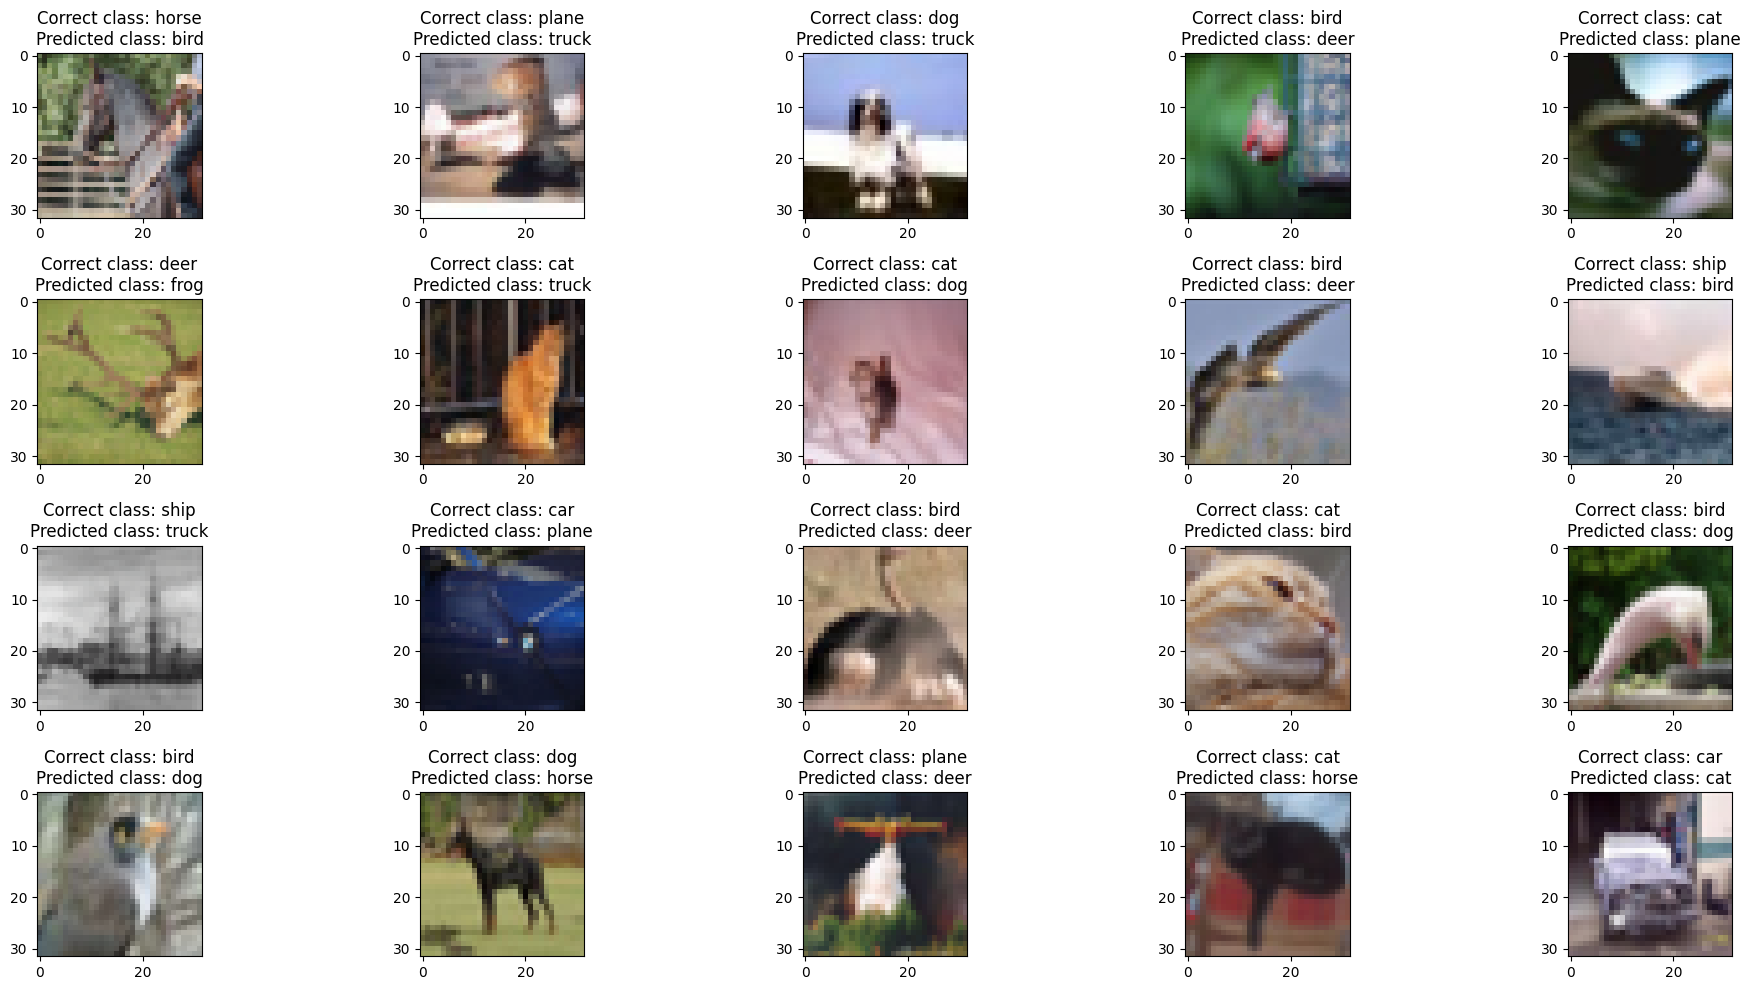

In [9]:
show_misclassified_images(
    misclassified_images[:20],
    predictions[:20],
    labels[:20],
    [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ],
);


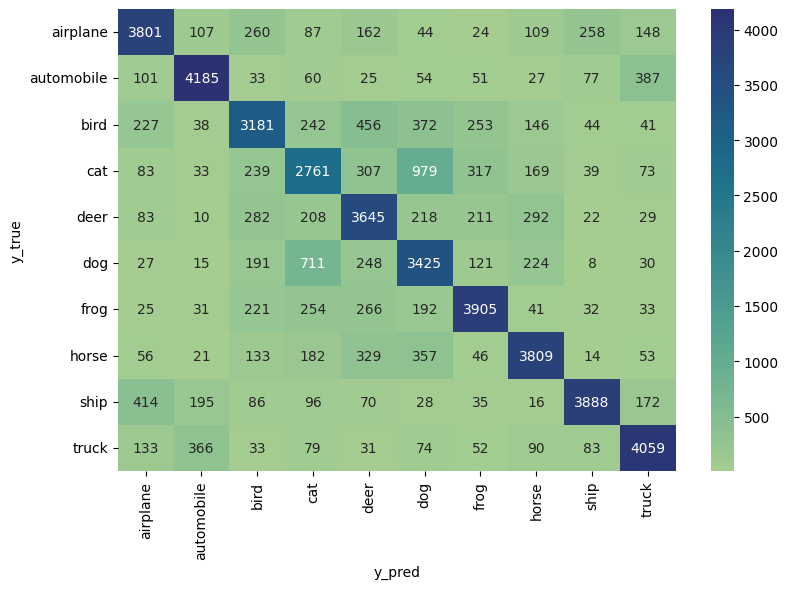

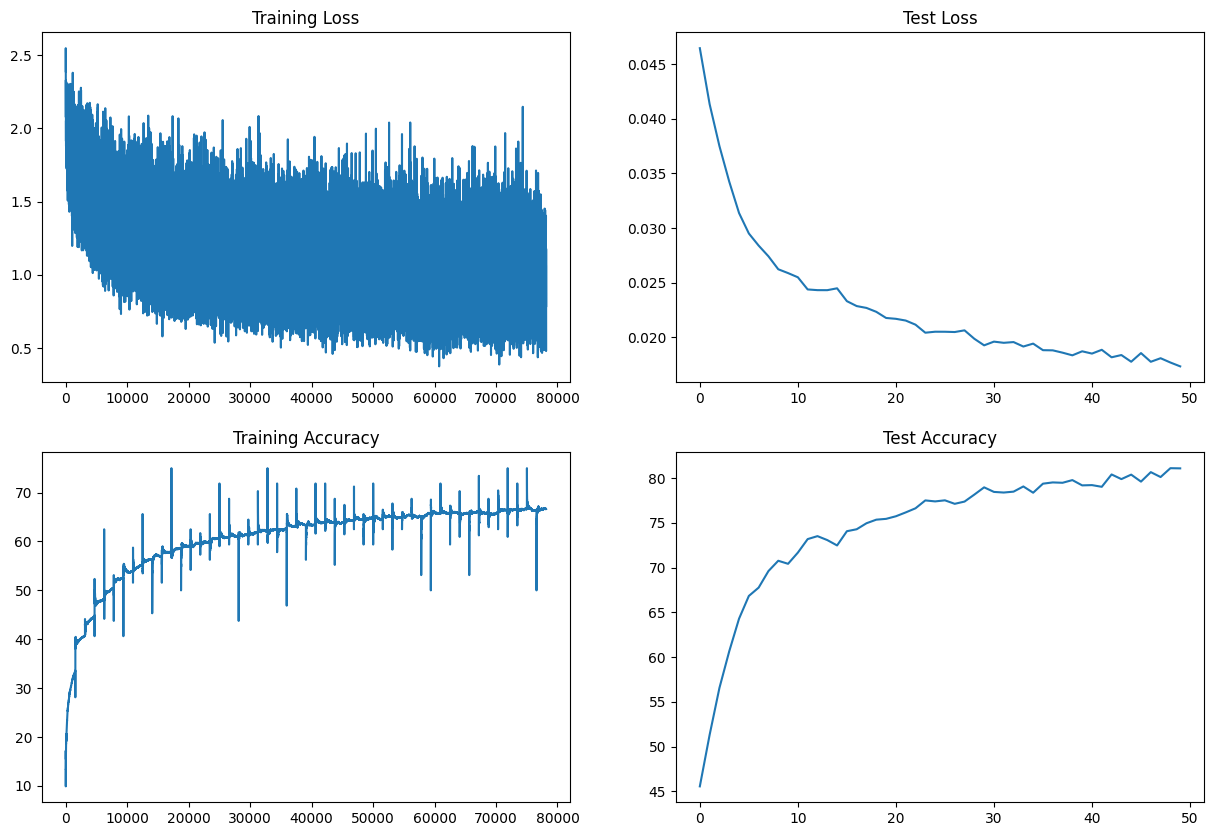

In [10]:
plot_confusion_matrix(model,train_loader,'cuda',train_loader.dataset.classes);
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies);

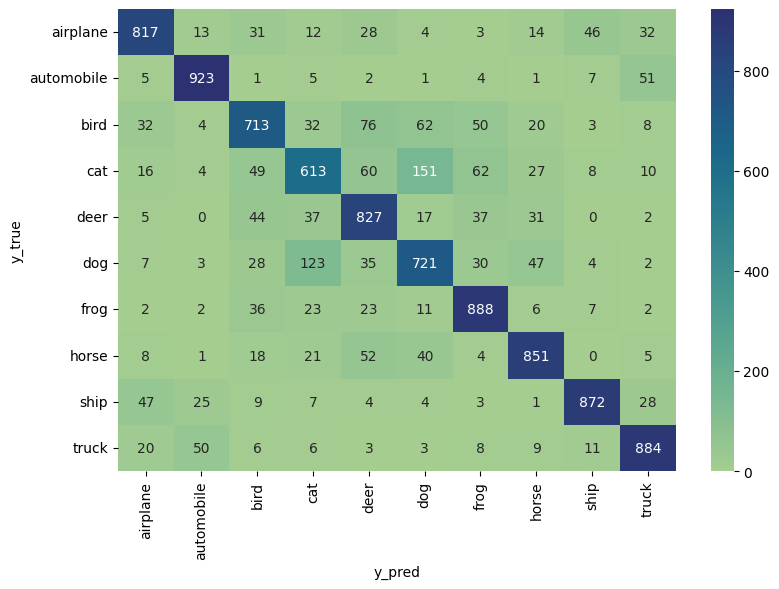

In [11]:
plot_confusion_matrix(model,test_loader,'cuda',test_loader.dataset.classes);